In [1]:
!pip install -U textblob
!pip install --upgrade pip
!pip install xgboost
!pip install wordcloud
!pip install numpy
!pip install pillow
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv('recession_2023_india_tweets_dataset.csv')

In [3]:
df.head()

,date,id,content,username,likeCount,retweetCount
0,2022-11-30 04:17:49+00:00,1597807084934172672,📌 @elonmusk begins hiring for Twitter 2.0 afte...,workflexitweets,1,1
1,2022-11-30 02:48:10+00:00,1597784522728558592,"Global Recession से दुनिया हुई बेहाल, लेकिन In...",indilinks,0,0
2,2022-11-29 17:21:57+00:00,1597642029479038976,Will global recession impact India or not? #re...,BizzBuzzNews,0,0
3,2022-11-29 11:40:40+00:00,1597556142213070850,Is Recession In India Coming Soon?\n\nWant to ...,Anubhav74782862,0,0
4,2022-11-29 10:12:57+00:00,1597534071202385922,A report by #realestate data collation &amp; r...,indiaoutbound,1,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5176 entries, 0 to 5175
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          5176 non-null   object
 1   id            5176 non-null   int64 
 2   content       5176 non-null   object
 3   username      5176 non-null   object
 4   likeCount     5176 non-null   int64 
 5   retweetCount  5176 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 242.8+ KB


In [5]:
df.isnull().sum()

date            0
id              0
content         0
username        0
likeCount       0
retweetCount    0
dtype: int64

In [6]:
df.columns

Index(['date', 'id', 'content', 'username', 'likeCount', 'retweetCount'], dtype='object')

In [7]:
text_df = df.drop(['date', 'id', 'username', 'likeCount',
       'retweetCount'], axis=1)
text_df.head()

,content
0,📌 @elonmusk begins hiring for Twitter 2.0 afte...
1,"Global Recession से दुनिया हुई बेहाल, लेकिन In..."
2,Will global recession impact India or not? #re...
3,Is Recession In India Coming Soon?\n\nWant to ...
4,A report by #realestate data collation &amp; r...


In [8]:
print(text_df['content'].iloc[0],"\n")
print(text_df['content'].iloc[1],"\n")
print(text_df['content'].iloc[2],"\n")
print(text_df['content'].iloc[3],"\n")
print(text_df['content'].iloc[4],"\n")

📌 @elonmusk begins hiring for Twitter 2.0 after firing nearly 5000 employees, reveals future plans

📌 @amazonIN likely to fire hundreds of workers in India next month
#Hiring #ELONMUSK #layoffs #Amazon #recession #layoff #job 

Global Recession से दुनिया हुई बेहाल, लेकिन India ने कर डाला बड़ा कमाल, आखिर कैसे चला भारत का सिक्का
#global #recession #globalrecession2022
#indilinksnews

https://t.co/ghnwjoMsj5 https://t.co/own7FgFqGR 

Will global recession impact India or not? #recession #USA #layoffs #realestatesector https://t.co/wU5DKBul9g 

Is Recession In India Coming Soon?

Want to know read our article: 
https://t.co/Yq6hoqOjv5

#recession #India https://t.co/IrEdXvIvVX 

A report by #realestate data collation &amp; research firm #CoStar says that appetite for new investments in hotels in #Europe has continued to grow, despite #RussiaUkraineWar, record-high #inflation &amp; even signs of a #recession. #IO @CoStarUS @alvarezmarsal

https://t.co/0QDn2ujQUm 



In [9]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5176 entries, 0 to 5175
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  5176 non-null   object
dtypes: object(1)
memory usage: 40.6+ KB


In [10]:
def data_processing(text):
    text = text.lower()
    text = re.sub(r"https\S+|www\S+https\S+", '',text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','',text)
    text = re.sub(r'[^\w\s]','',text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return " ".join(filtered_text)

In [11]:
text_df.content = text_df['content'].apply(data_processing)
text_df = text_df.drop_duplicates('content')

In [12]:
stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

In [13]:
text_df['content'] = text_df['content'].apply(lambda x: stemming(x))

In [14]:
text_df.head()

,content
0,elonmusk begins hiring twitter 20 firing nearl...
1,global recession स दनय हई बहल लकन india न कर ड...
2,global recession impact india recession usa la...
3,recession india coming soon want know read art...
4,report realestate data collation amp research ...


In [15]:
print(text_df['content'].iloc[0],"\n")
print(text_df['content'].iloc[1],"\n")
print(text_df['content'].iloc[2],"\n")
print(text_df['content'].iloc[3],"\n")
print(text_df['content'].iloc[4],"\n")

elonmusk begins hiring twitter 20 firing nearly 5000 employees reveals future plans amazonin likely fire hundreds workers india next month hiring elonmusk layoffs amazon recession layoff job 

global recession स दनय हई बहल लकन india न कर डल बड कमल आखर कस चल भरत क सकक global recession globalrecession2022 indilinksnews 

global recession impact india recession usa layoffs realestatesector 

recession india coming soon want know read article recession india 

report realestate data collation amp research firm costar says appetite new investments hotels europe continued grow despite russiaukrainewar recordhigh inflation amp even signs recession io costarus alvarezmarsal 



In [16]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4885 entries, 0 to 5175
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  4885 non-null   object
dtypes: object(1)
memory usage: 76.3+ KB


In [17]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

In [18]:
text_df['polarity'] = text_df['content'].apply(polarity)

In [19]:
text_df.head(10)

,content,polarity
0,elonmusk begins hiring twitter 20 firing nearl...,0.025000
1,global recession स दनय हई बहल लकन india न कर ड...,0.000000
2,global recession impact india recession usa la...,0.000000
3,recession india coming soon want know read art...,0.000000
4,report realestate data collation amp research ...,-0.031818
5,see bcz india unlike west culture savings gene...,0.000000
6,indias crude import basket 10month low pump pr...,-0.010000
7,likely recession us could cause concern histor...,0.116667
8,im getting phone calls south africa india chas...,-0.500000
9,இநதயவன உணமயன நலம எனன ரசஷன அசசம உளளத india econ...,0.000000


In [20]:
def sentiment(label):
    if label <0:
        return "Negative"
    elif label ==0:
        return "Neutral"
    elif label>0:
        return "Positive"

In [21]:
text_df['sentiment'] = text_df['polarity'].apply(sentiment)

In [22]:
text_df.head()

,content,polarity,sentiment
0,elonmusk begins hiring twitter 20 firing nearl...,0.025000,Positive
1,global recession स दनय हई बहल लकन india न कर ड...,0.000000,Neutral
2,global recession impact india recession usa la...,0.000000,Neutral
3,recession india coming soon want know read art...,0.000000,Neutral
4,report realestate data collation amp research ...,-0.031818,Negative


<Axes: xlabel='sentiment', ylabel='count'>

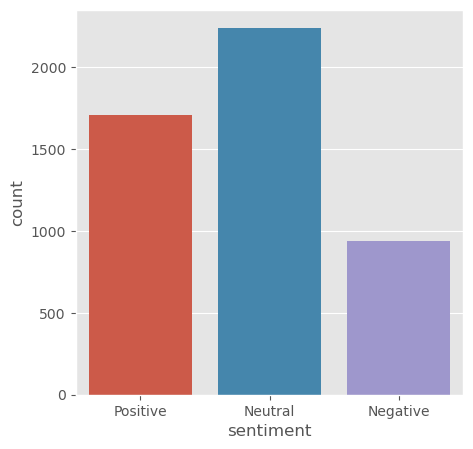

In [23]:
fig = plt.figure(figsize=(5,5))
sns.countplot(x='sentiment', data = text_df)

Text(0.5, 1.0, 'Distribution of sentiments')

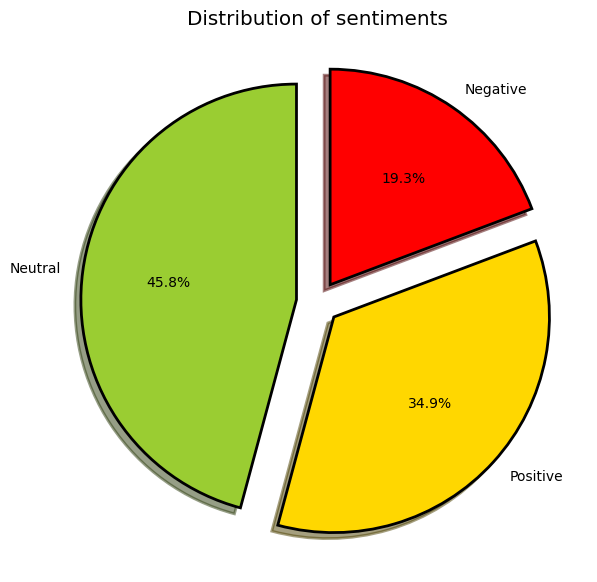

In [24]:
fig = plt.figure(figsize=(7,7))
colors = ("yellowgreen", "gold", "red")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = text_df['sentiment'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

In [25]:
pos_tweets = text_df[text_df.sentiment == 'Positive']
pos_tweets = pos_tweets.sort_values(['polarity'], ascending= False)
pos_tweets.head()

,content,polarity,sentiment
2742,best 5 headphones india understand buy headpho...,1.0,Positive
2720,perfect time ask uk pay reparations owed india...,1.0,Positive
753,india outperform best sectors invest market ou...,1.0,Positive
3741,mtch tinder works india amp china tested best ...,1.0,Positive
328,youtube link mrray dalio warns perfect storm e...,1.0,Positive


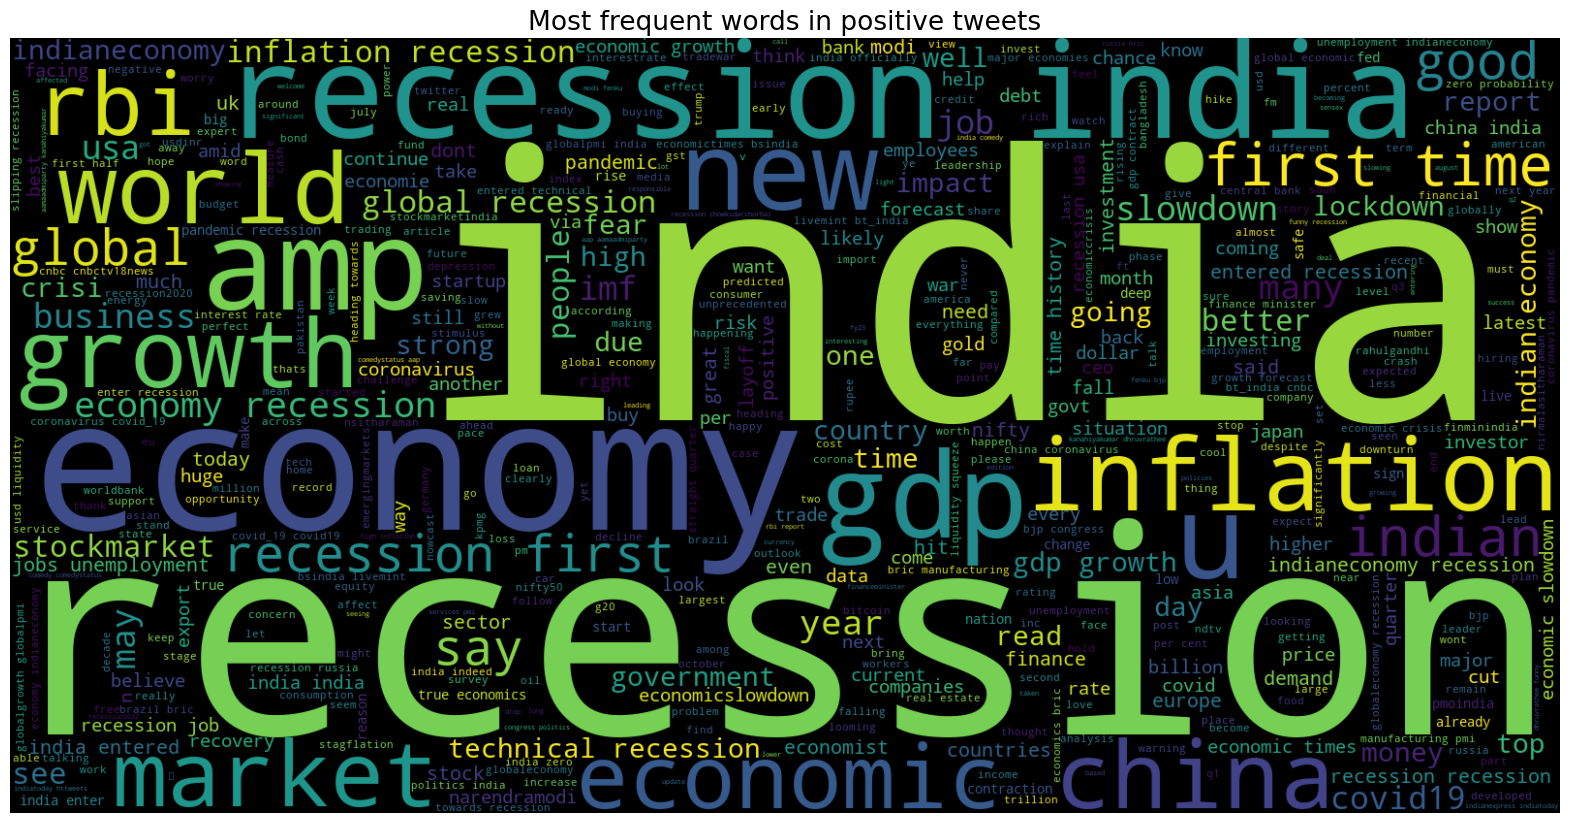

In [26]:
text = ' '.join([word for word in pos_tweets['content']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in positive tweets', fontsize=19)
plt.show()

In [27]:
neg_tweets = text_df[text_df.sentiment == 'Negative']
neg_tweets = neg_tweets.sort_values(['polarity'], ascending= False)
neg_tweets.head()


,content,polarity,sentiment
2881,vuca stands volatile uncertain complex ambiguo...,-0.003571,Negative
2891,vuca stands volatile uncertain complex ambiguo...,-0.003571,Negative
2002,india suffering one biggest recession know man...,-0.004630,Negative
2633,sanjay_ldg rachitseth puru_ag jr finance minis...,-0.004762,Negative
4534,mallyagate us recession mainly due bad loans m...,-0.006250,Negative


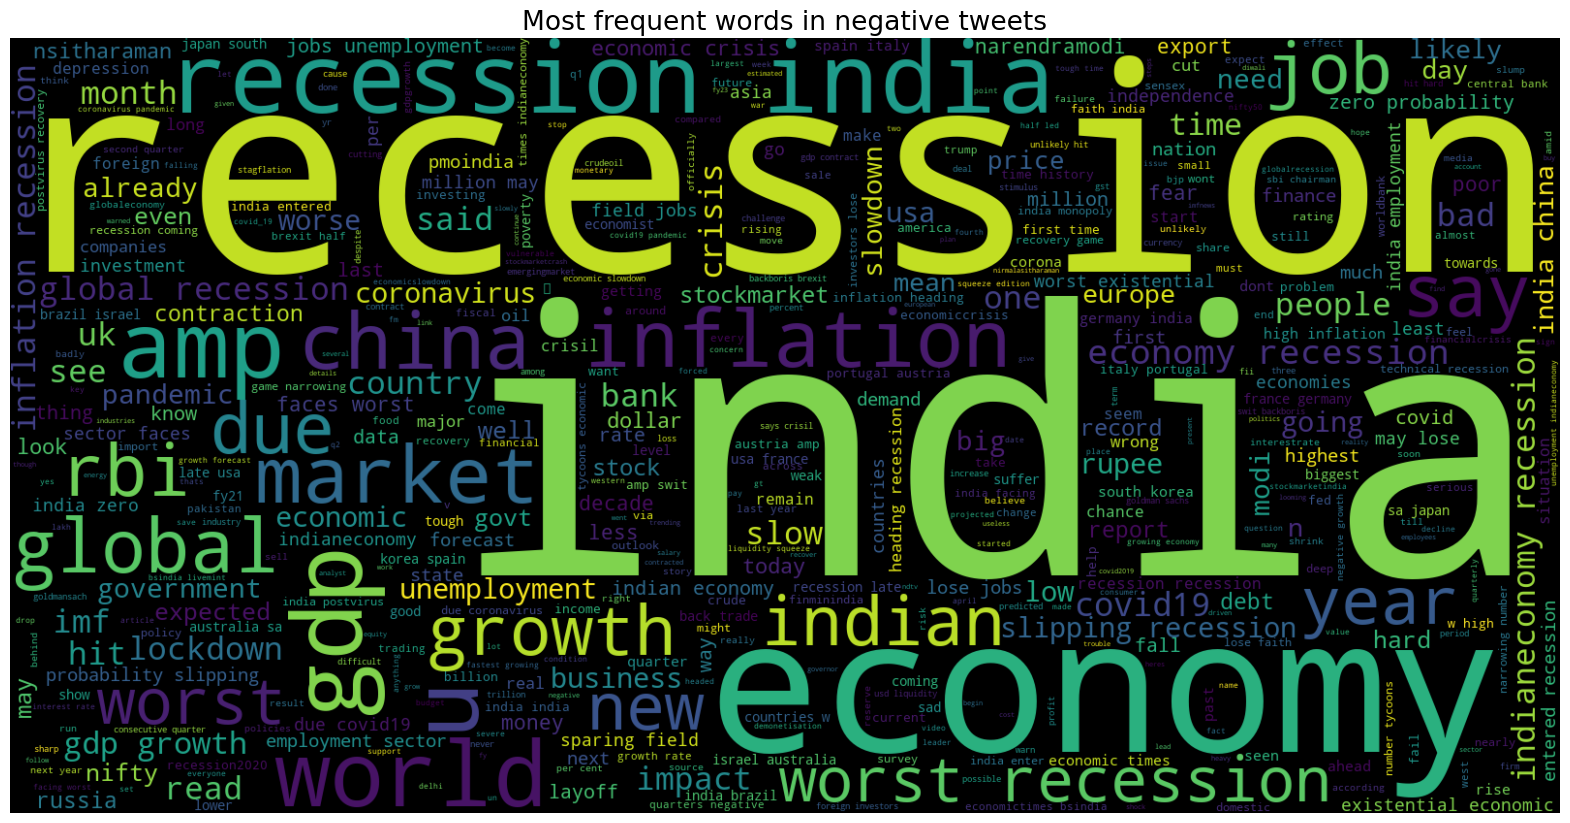

In [28]:
text = ' '.join([word for word in neg_tweets['content']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in negative tweets', fontsize=19)
plt.show()

In [29]:
neutral_tweets = text_df[text_df.sentiment == 'Neutral']
neutral_tweets = neutral_tweets.sort_values(['polarity'], ascending= False)
neutral_tweets.head()

,content,polarity,sentiment
1,global recession स दनय हई बहल लकन india न कर ड...,0.0,Neutral
3696,view india cant get without big bang india ban...,0.0,Neutral
3687,spy qqq em india recession,0.0,Neutral
3688,3000 करमचरय क नकर पर खतर टट सटल करन ज रह ह छटन...,0.0,Neutral
3689,ab bhakts aake comment krenge economicslowdown...,0.0,Neutral


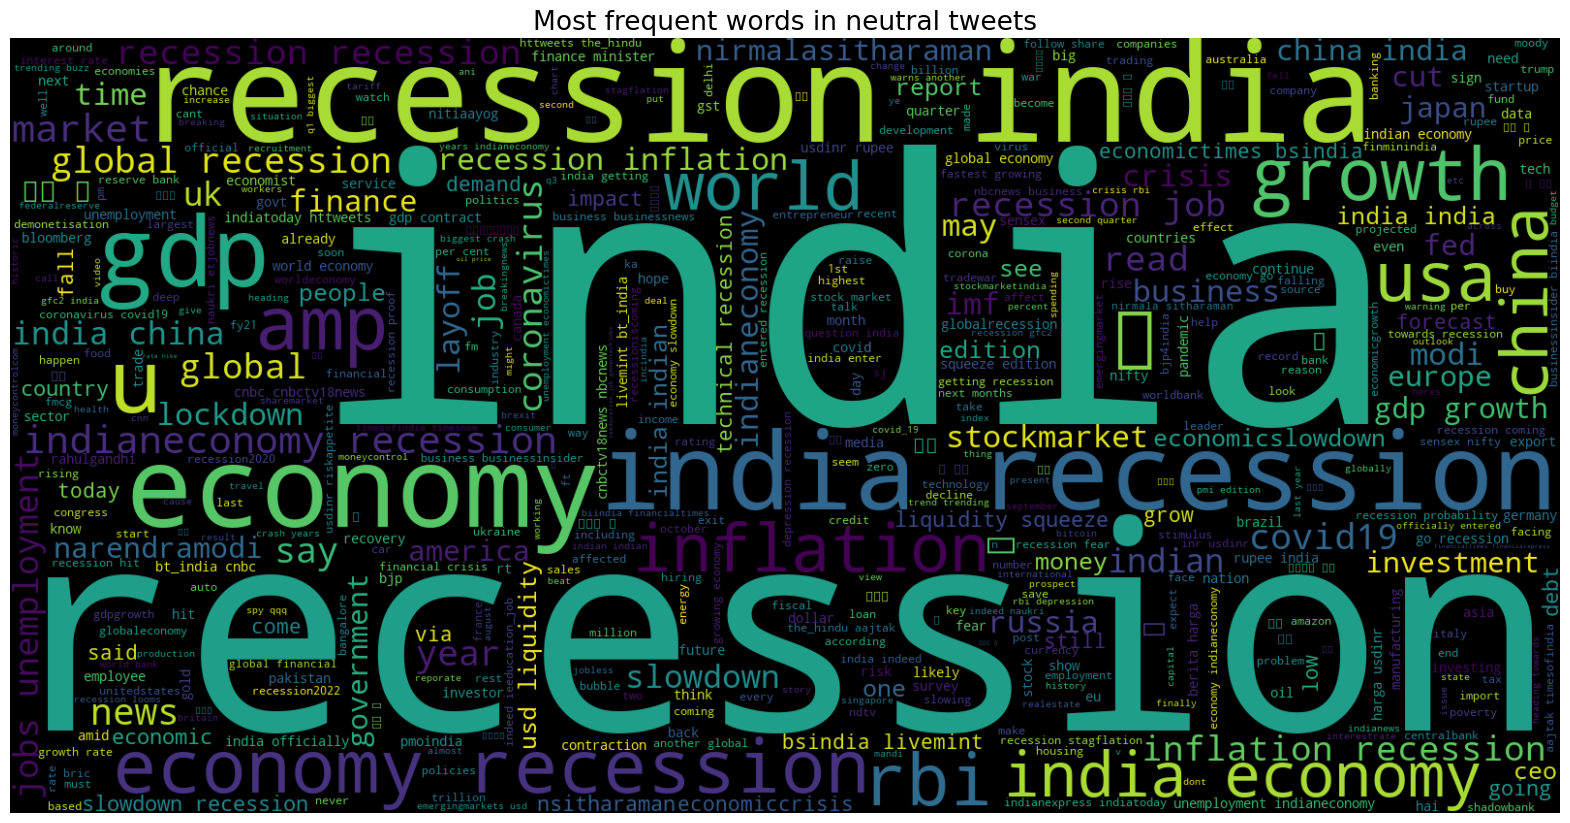

In [30]:
text = ' '.join([word for word in neutral_tweets['content']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in neutral tweets', fontsize=19)
plt.show()

In [31]:
vect = CountVectorizer(ngram_range=(1,2)).fit(text_df['content'])

In [32]:
feature_names = vect.get_feature_names_out()
print("Number of features: {}\n".format(len(feature_names)))
print("First 20 features:\n {}".format(feature_names[:20]))

Number of features: 75163

First 20 features:
 ['000' '000 percentage' '00200' '00200 crash' '01' '01 dip'
 '01 switzerland' '010' '010 usa' '02' '02 25' '02 june' '02 khabarchhe'
 '02 since' '025' '025 canada' '03' '03 per' '04' '04 32']


In [33]:
X = text_df['content']
Y = text_df['sentiment']
X = vect.transform(X)


In [34]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [35]:
print("Size of x_train:", (x_train.shape))
print("Size of y_train:", (y_train.shape))
print("Size of x_test:", (x_test.shape))
print("Size of y_test:", (y_test.shape))

Size of x_train: (3419, 75163)
Size of y_train: (3419,)
Size of x_test: (1466, 75163)
Size of y_test: (1466,)


In [36]:
# XGBoost
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

xgb_model = xgb.XGBClassifier()
xgb_model.fit(x_train, y_train_encoded)

xgb_pred = xgb_model.predict(x_test)
xgb_acc = accuracy_score(y_test_encoded, xgb_pred)
print("Test accuracy: {:.2f}%".format(xgb_acc*100))

print(confusion_matrix(y_test_encoded, xgb_pred))
print("\n")
print(classification_report(y_test_encoded, xgb_pred))



Test accuracy: 85.33%
[[177  56  31]
 [  4 651   5]
 [ 27  92 423]]


              precision    recall  f1-score   support

           0       0.85      0.67      0.75       264
           1       0.81      0.99      0.89       660
           2       0.92      0.78      0.85       542

    accuracy                           0.85      1466
   macro avg       0.86      0.81      0.83      1466
weighted avg       0.86      0.85      0.85      1466



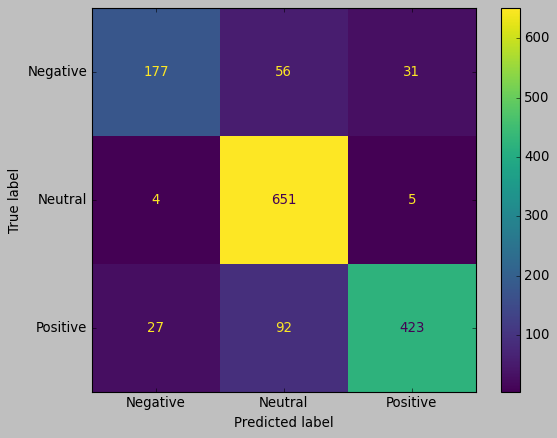

In [38]:
style.use('classic')
cm = confusion_matrix(y_test_encoded, xgb_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot()
plt.show()

In [39]:
# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(x_train, y_train)

nb_pred = nb_model.predict(x_test)
nb_acc = accuracy_score(nb_pred, y_test)
print("Test accuracy: {:.2f}%".format(nb_acc*100))

print(confusion_matrix(y_test, nb_pred))
print("\n")
print(classification_report(y_test, nb_pred))



Test accuracy: 69.44%
[[123  38 103]
 [ 44 473 143]
 [ 43  77 422]]


              precision    recall  f1-score   support

    Negative       0.59      0.47      0.52       264
     Neutral       0.80      0.72      0.76       660
    Positive       0.63      0.78      0.70       542

    accuracy                           0.69      1466
   macro avg       0.67      0.65      0.66      1466
weighted avg       0.70      0.69      0.69      1466



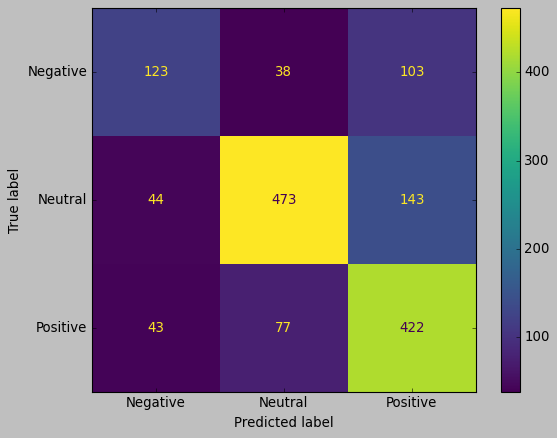

In [40]:
style.use('classic')
cm = confusion_matrix(y_test, nb_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot()
plt.show()

In [41]:
# KNN
knn_model = KNeighborsClassifier()
knn_model.fit(x_train, y_train)

knn_pred = knn_model.predict(x_test)
knn_acc = accuracy_score(knn_pred, y_test)
print("Test accuracy: {:.2f}%".format(knn_acc*100))

print(confusion_matrix(y_test, knn_pred))
print("\n")
print(classification_report(y_test, knn_pred))



Test accuracy: 49.73%
[[ 22 241   1]
 [  0 659   1]
 [  5 489  48]]


              precision    recall  f1-score   support

    Negative       0.81      0.08      0.15       264
     Neutral       0.47      1.00      0.64       660
    Positive       0.96      0.09      0.16       542

    accuracy                           0.50      1466
   macro avg       0.75      0.39      0.32      1466
weighted avg       0.72      0.50      0.38      1466



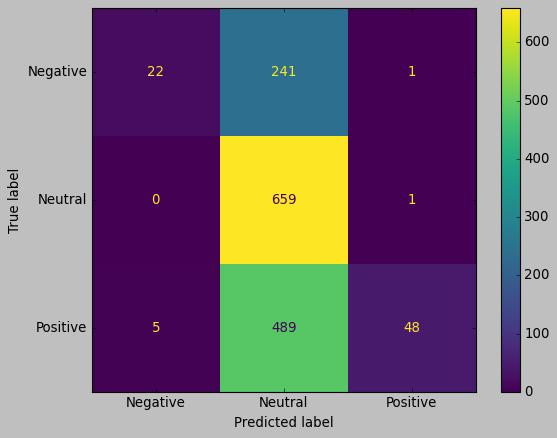

In [43]:
style.use('classic')
cm = confusion_matrix(y_test, knn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot()
plt.show()

In [50]:
#SVM
svm_model = svm.SVC()
svm_model.fit(x_train, y_train_encoded)

svm_pred = svm_model.predict(x_test)
svm_acc = accuracy_score(y_test_encoded, svm_pred)
print("Test accuracy: {:.2f}%".format(svm_acc*100))

print(confusion_matrix(y_test_encoded, svm_pred))
print("\n")
print(classification_report(y_test_encoded, svm_pred))



Test accuracy: 69.10%
[[ 59 101 104]
 [  1 595  64]
 [  6 177 359]]


              precision    recall  f1-score   support

           0       0.89      0.22      0.36       264
           1       0.68      0.90      0.78       660
           2       0.68      0.66      0.67       542

    accuracy                           0.69      1466
   macro avg       0.75      0.60      0.60      1466
weighted avg       0.72      0.69      0.66      1466



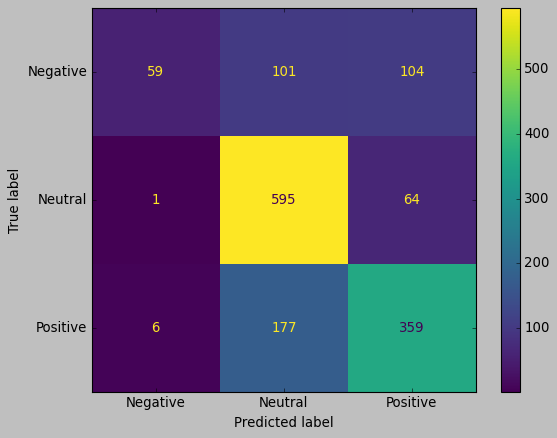

In [45]:
style.use('classic')
cm = confusion_matrix(y_test_encoded, svm_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot()
plt.savefig('confusion_matrix.png')

plt.show()

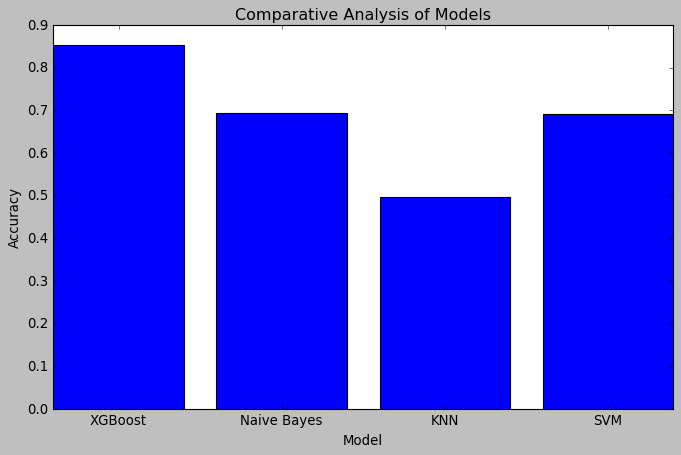

         Model  Accuracy
0      XGBoost  0.853342
1  Naive Bayes  0.694407
2          KNN  0.497271
3          SVM  0.690996


In [46]:
# Define the models and their corresponding accuracy scores
models = [
    ('XGBoost', xgb_acc),
    ('Naive Bayes', nb_acc),
    ('KNN', knn_acc),
    ('SVM', svm_acc)
]

# Create a dataframe to store the results
df = pd.DataFrame(models, columns=['Model', 'Accuracy'])

# Plot the results using a bar chart
plt.figure(figsize=(10, 6))
plt.bar(df['Model'], df['Accuracy'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparative Analysis of Models')
plt.show()
#Table 
table = pd.DataFrame(df['Accuracy'].values, columns=['Accuracy'])
table.insert(0, 'Model', df['Model'])
print(table)

SVM Decoded Predictions: ['Positive' 'Positive' 'Positive' 'Neutral' 'Positive' 'Positive'
 'Neutral' 'Neutral' 'Positive' 'Neutral']
XGBoost Decoded Predictions: ['Positive' 'Positive' 'Neutral' 'Neutral' 'Negative' 'Neutral' 'Neutral'
 'Neutral' 'Positive' 'Neutral']
Actual Labels: 1184    Positive
408     Positive
1305     Neutral
4466     Neutral
1854    Negative
4400     Neutral
2422     Neutral
5116     Neutral
4233    Positive
4197     Neutral
Name: sentiment, dtype: object
KNN - Actual Counts: Counter({'Neutral': 660, 'Positive': 542, 'Negative': 264})
KNN - Predicted Counts: Counter({'Neutral': 1389, 'Positive': 50, 'Negative': 27})


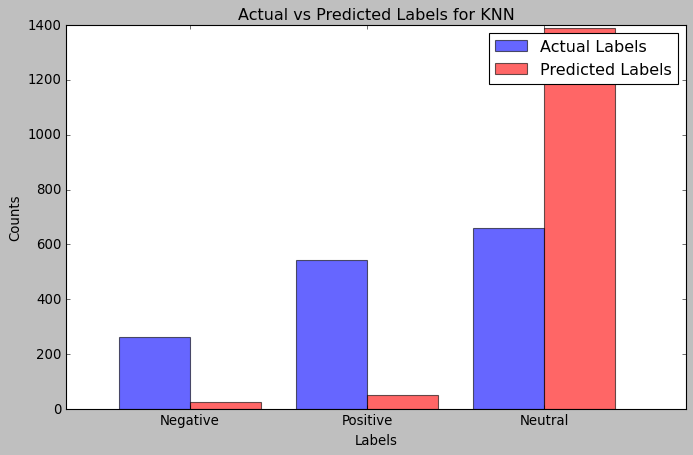

XGBoost - Actual Counts: Counter({'Neutral': 660, 'Positive': 542, 'Negative': 264})
XGBoost - Predicted Counts: Counter({'Neutral': 799, 'Positive': 459, 'Negative': 208})


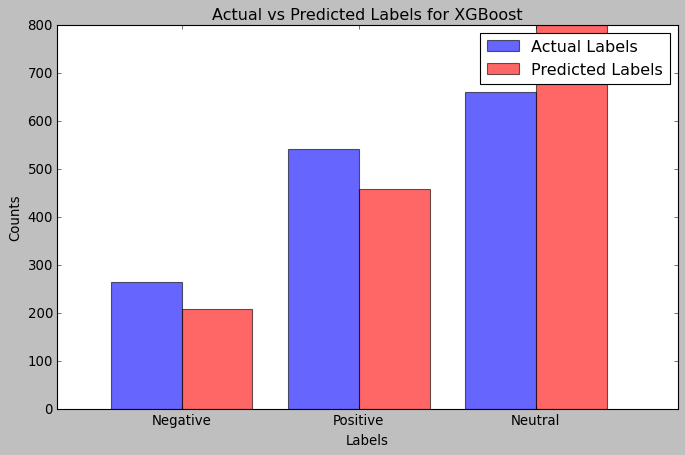

Naive Bayes - Actual Counts: Counter({'Neutral': 660, 'Positive': 542, 'Negative': 264})
Naive Bayes - Predicted Counts: Counter({'Positive': 668, 'Neutral': 588, 'Negative': 210})


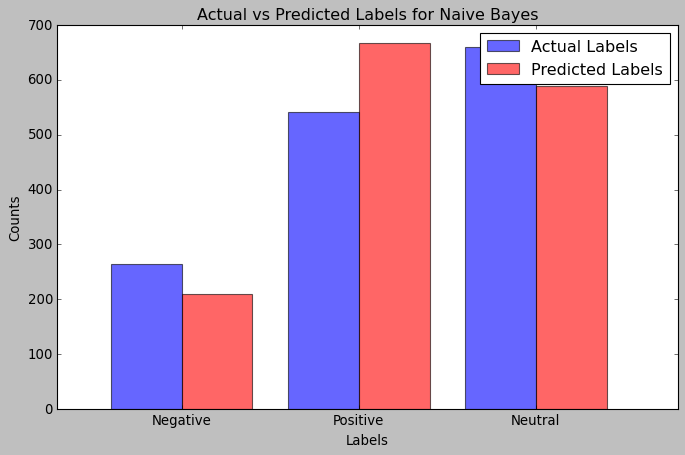

SVM - Actual Counts: Counter({'Neutral': 660, 'Positive': 542, 'Negative': 264})
SVM - Predicted Counts: Counter({'Neutral': 873, 'Positive': 527, 'Negative': 66})


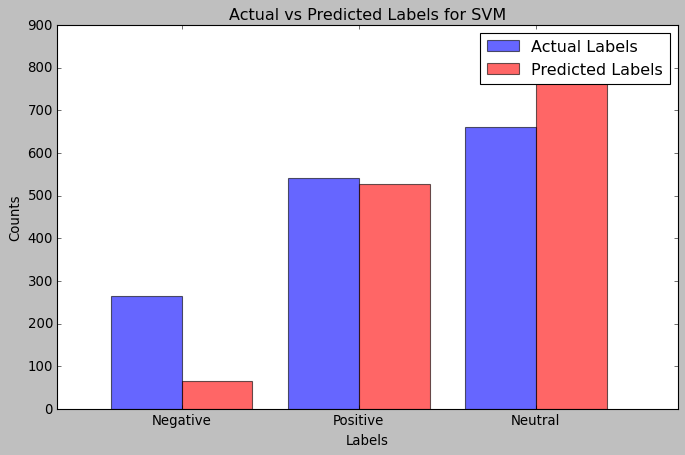

In [47]:
import matplotlib.pyplot as plt
from collections import Counter

# Assuming you have these predictions already made
# knn_pred = KNN model predictions (not encoded)
# xgb_pred = XGBoost model predictions (encoded)
# nb_pred = Naive Bayes model predictions (not encoded)
# svm_pred = SVM model predictions (encoded)

# Decode SVM and XGBoost predictions back to the original labels
svm_pred_decoded = le.inverse_transform(svm_pred)
xgb_pred_decoded = le.inverse_transform(xgb_pred)

# Debug: Print the first few predictions to check
print("SVM Decoded Predictions:", svm_pred_decoded[:10])
print("XGBoost Decoded Predictions:", xgb_pred_decoded[:10])
print("Actual Labels:", y_test[:10])

# Store predictions for each model in a dictionary
predictions = {
    'KNN': knn_pred,
    'XGBoost': xgb_pred_decoded,
    'Naive Bayes': nb_pred,
    'SVM': svm_pred_decoded
}

# Plotting for each model separately
for model_name, preds in predictions.items():
    # Count occurrences
    actual_counts = Counter(y_test)
    predicted_counts = Counter(preds)
    
    # Create lists of labels and their counts for plotting
    labels = list(set(y_test) | set(preds))
    actual_values = [actual_counts.get(label, 0) for label in labels]
    predicted_values = [predicted_counts.get(label, 0) for label in labels]
    
    # Debug: Print label counts for verification
    print(f"{model_name} - Actual Counts:", actual_counts)
    print(f"{model_name} - Predicted Counts:", predicted_counts)
    
    # Plotting
    x = range(len(labels))
    plt.figure(figsize=(10, 6))
    plt.bar(x, actual_values, width=0.4, label='Actual Labels', align='center', color='b', alpha=0.6)
    plt.bar([p + 0.4 for p in x], predicted_values, width=0.4, label='Predicted Labels', align='center', color='r', alpha=0.6)
    plt.xlabel('Labels')
    plt.ylabel('Counts')
    plt.title(f'Actual vs Predicted Labels for {model_name}')
    plt.xticks([p + 0.2 for p in x], labels)
    plt.legend()
    plt.show()


In [51]:
import pickle
with open('XGBoost.pkl','wb') as model_file:
    pickle.dump(xgb_model, model_file)

In [52]:
import pickle
vect = CountVectorizer(ngram_range=(1,2)).fit(text_df['content'])
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vect, f)